In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
from sklearn.decomposition import FastICA, KernelPCA, RandomizedPCA
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

/home/sasha/Projects/blackbox/blackbox/env3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/sasha/Projects/blackbox/blackbox/env3.5/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
states = np.load("./checkpoints_greedy_bot/greedy_states_no_repeat_300fwd2.npy")
actions = np.load("./checkpoints_greedy_bot/greedy_actions_no_repeat_300fwd2.npy")
rewards = np.load("./checkpoints_greedy_bot/greedy_rewards_no_repeat_300fwd2.npy")

In [23]:
mask = (states[:, 35] != 0)
masked_states = states[mask]
norm_states = masked_states[:, :35] / masked_states[:, 35, np.newaxis]

In [25]:
def get_mult_states(states):
    return states[:, :35] * states[:, 35, np.newaxis]

def make_batch(states, offset, size):
    batch_states = states[offset:offset+size, :]
    state_size = states.shape[1]
    multiplied_state_size = state_size - 1
    full_step_info_size = multiplied_state_size + state_size
    n_steps_in_unit = 2
    undef_value = -100000
    result_width = n_steps_in_unit * full_step_info_size
    result = np.ones((size, result_width), dtype=float) * undef_value
    for idx in range(n_steps_in_unit):
        state_offset = idx * (full_step_info_size)
        delayed_states = states[offset - idx:offset + size - idx, :]
        result[:, state_offset: state_offset + state_size] = delayed_states
        result[:, 
               state_offset + state_size:
               state_offset + state_size + multiplied_state_size] = get_mult_states(delayed_states)
    return result
make_batch(states, 10, 2)

array([[ -7.33345866e-01,  -9.66022253e-01,  -9.67800796e-01,
          1.53445140e-01,   1.70717463e-01,   5.76924682e-01,
         -6.60002232e-01,  -2.03111991e-01,  -6.15479410e-01,
          1.29375792e+00,  -7.44509459e-01,  -1.45893419e+00,
         -5.05303256e-02,  -1.21013689e+00,   9.06343579e-01,
         -3.36546600e-01,   2.99922705e-01,  -6.12462342e-01,
         -6.47838175e-01,  -4.50952500e-01,   2.43804604e-01,
          1.16218853e+00,   2.42853954e-01,  -4.86808941e-02,
          8.03747416e-01,   4.93916869e-01,   2.01479033e-01,
         -8.30623284e-02,  -2.79198259e-01,  -4.53836530e-01,
          1.15699738e-01,  -4.48449582e-01,   1.51374531e+00,
         -9.94985640e-01,   8.73658359e-01,   0.00000000e+00,
         -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         -0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
          0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
        

In [61]:
extended_states = np.empty((states.shape[0], 2 * states.shape[1] - 1), dtype=float)
extended_states[:, :states.shape[1]] = states
extended_states[:, states.shape[1]:] = states[:, :35] * states[:, 35, np.newaxis]

In [62]:
%%time
from sklearn.svm import LinearSVR

X = extended_states

regressors = [LinearSVR(C=10) for _ in range(4)]

for action, r in enumerate(regressors):
    r.fit(X, rewards[:, action])
    
coefs = np.zeros((4, X.shape[1] + 1))

for idx, r in enumerate(regressors):
    coefs[idx, :-1] = r.coef_
    coefs[idx, -1] = r.intercept_
np.save("coefs.npy", coefs)

ValueError: could not broadcast input array from shape (71) into shape (36)

In [46]:
coefs

array([[  4.60920777e-01,  -4.10884249e-02,   1.19312890e-01,
          1.37855721e-02,   1.76595424e-02,  -9.59694627e-01,
         -9.31116247e-01,   3.51075313e-01,   1.96178503e-01,
          1.59375720e-01,   1.51516560e-01,   1.54852588e-01,
          4.59056859e-02,   2.36626273e-02,  -2.07354885e-01,
         -1.07873901e-01,   1.00599894e+00,  -3.30653626e-01,
         -6.85377241e-01,  -9.44999194e-01,   6.30214235e-02,
          8.94250306e-01,  -1.54450119e-01,  -3.10089071e-01,
         -4.12312595e-01,  -1.29415032e+00,  -7.63009021e-01,
         -1.91824755e-01,  -6.40627455e-01,   1.44129602e+00,
          3.93492650e-01,  -4.79641637e-02,   3.99919588e-01,
         -3.10453755e-01,  -2.65766900e-01,   1.27431950e-01,
          2.04148161e+01],
       [  4.80626149e-01,  -4.61047395e-02,   1.20839663e-01,
          4.33259591e-02,   9.41181225e-03,  -9.45000423e-01,
         -8.43280135e-01,   4.07925888e-01,   1.75652480e-01,
          2.18214314e-01,   1.27770721e-01,

In [65]:
from sklearn.metrics import mean_squared_error as MSE
for action, r in enumerate(regressors):
    print(MSE(rewards[:, action], r.predict(extended_states)))
    # print(MSE(rewards[:, action], extended_states.dot(coefs[action, :-1]) + coefs[action, -1]))
    print()

387.712914152

387.562404754

387.275472489

386.704392057



In [6]:
pd_norm_states = pd.DataFrame(data=norm_states)
pd_norm_states.describe()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
count,1.167543e+06,1.167543e+06,1.167543e+06,1.167543e+06,1.167543e+06,1.167543e+06,1.167543e+06,1.167543e+06,1.167543e+06,1.167543e+06,...,1.167543e+06,1.167543e+06,1.167543e+06,1.167543e+06,1.167543e+06,1.167543e+06,1.167543e+06,1.167543e+06,1.167543e+06,1.167543e+06
mean,1.355000e-03,7.543733e-02,1.875647e-01,2.277180e-02,2.297193e-02,1.301750e-01,-1.515350e-01,1.224953e-01,-1.446214e-01,1.177450e-01,...,-4.885402e-01,4.887707e-01,-6.289488e-01,6.214675e-01,-4.720941e-01,4.731386e-01,-2.160145e-01,2.383495e-01,-4.370914e-02,7.173324e-02
std,3.485963e+00,3.467990e+00,3.451480e+00,3.482040e+00,3.484025e+00,3.229220e+00,3.249385e+00,3.300417e+00,3.332945e+00,3.424593e+00,...,3.067059e+00,3.128332e+00,3.199852e+00,3.252687e+00,3.423520e+00,3.373655e+00,3.388284e+00,3.399120e+00,3.365883e+00,3.434494e+00
min,-4.216060e+01,-1.520464e+01,-1.399226e+01,-2.086210e+01,-2.360041e+01,-5.656085e+01,-8.538275e+01,-4.073099e+01,-4.165016e+01,-1.610549e+01,...,-3.938857e+01,-4.041090e+01,-3.375846e+01,-3.663985e+01,-6.032743e+01,-4.243889e+01,-6.694309e+01,-7.100039e+01,-5.329312e+01,-6.741731e+01
25%,-1.332872e+00,-1.322161e+00,-1.266126e+00,-1.278820e+00,-1.241696e+00,-9.382297e-01,-1.153193e+00,-8.718746e-01,-1.070878e+00,-1.293758e+00,...,-1.336862e+00,-3.590862e-01,-1.391227e+00,-1.229310e-01,-1.328223e+00,-3.938319e-01,-1.186443e+00,-7.379015e-01,-7.613644e-01,-8.016587e-01
50%,5.503135e-01,6.824757e-01,8.731998e-01,1.375569e-03,1.637754e-03,5.970552e-01,-6.000020e-01,3.934686e-01,-4.288695e-01,6.961650e-01,...,-4.721279e-01,4.666328e-01,-6.340791e-01,6.319873e-01,-5.271444e-01,5.229383e-01,-2.391013e-01,2.541477e-01,-8.384840e-02,8.689737e-02
75%,1.330322e+00,1.375143e+00,1.431483e+00,1.280241e+00,1.263477e+00,1.165606e+00,9.428603e-01,1.023532e+00,8.792563e-01,1.437509e+00,...,3.530838e-01,1.333361e+00,1.256217e-01,1.390799e+00,3.870494e-01,1.361490e+00,6.508307e-01,1.268908e+00,6.093909e-01,9.243855e-01
max,4.981630e+01,1.552886e+01,1.423462e+01,1.975024e+01,2.198980e+01,4.942709e+01,5.043786e+01,4.202332e+01,4.034743e+01,1.558858e+01,...,3.938857e+01,4.041090e+01,5.043235e+01,3.867166e+01,6.032743e+01,6.190408e+01,6.694309e+01,7.100039e+01,5.329312e+01,6.741731e+01


In [49]:
pd_states = pd.DataFrame(data=states)
pd_states.describe()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
count,1.214494e+06,1.214494e+06,1.214494e+06,1.214494e+06,1.214494e+06,1.214494e+06,1.214494e+06,1.214494e+06,1.214494e+06,1.214494e+06,...,1.214494e+06,1.214494e+06,1.214494e+06,1.214494e+06,1.214494e+06,1.214494e+06,1.214494e+06,1.214494e+06,1.214494e+06,1.214494e+06
mean,-4.979721e-07,9.577342e-07,-7.221100e-07,2.506577e-08,-2.191582e-08,-5.365520e-07,-5.629046e-07,-5.027193e-07,-4.826331e-07,-6.743729e-07,...,-8.163762e-08,3.746768e-07,-9.114423e-08,2.464853e-08,5.325410e-07,7.217141e-08,5.648592e-07,2.823955e-07,-1.616903e-07,-2.118002e-03
std,1.000000e+00,1.000001e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.512300e-01
min,-7.769827e-01,-1.414294e+00,-1.306795e+00,-2.089417e+00,-2.360041e+00,-6.567608e-01,-6.600022e-01,-6.103122e-01,-6.154794e-01,-8.065752e-01,...,-4.041090e+00,-5.043235e+00,-5.156866e+00,-6.032743e+00,-6.190408e+00,-6.694309e+00,-7.100039e+00,-5.329312e+00,-6.741731e+00,-1.100000e+00
25%,-7.129820e-01,-9.832100e-01,-9.795152e-01,-9.480924e-01,-8.662639e-01,-6.567608e-01,-6.600022e-01,-6.103122e-01,-6.154794e-01,-7.673503e-01,...,-5.940006e-01,-6.716134e-01,-6.779371e-01,-6.985496e-01,-7.078588e-01,-6.402012e-01,-6.951263e-01,-3.224138e-01,-5.175193e-01,-7.000000e-01
50%,-6.577087e-01,-5.752982e-01,-6.152166e-01,1.238012e-03,-1.310203e-03,-6.567608e-01,-6.600022e-01,-6.103122e-01,-6.154794e-01,-7.328324e-01,...,-5.240371e-02,-1.283331e-01,-1.229928e-01,-1.285858e-01,-1.138952e-01,-5.983413e-02,-1.272172e-01,5.165226e-02,-1.829813e-02,0.000000e+00
75%,1.329640e+00,1.054979e+00,1.054258e+00,9.463611e-01,8.659436e-01,5.925999e-01,5.701564e-01,4.513526e-01,4.442657e-01,1.293758e+00,...,5.740787e-01,5.858223e-01,5.984735e-01,6.009765e-01,5.745376e-01,5.189805e-01,6.458073e-01,6.487858e-01,7.441456e-01,7.000000e-01
max,1.133517e+01,1.572714e+00,1.484734e+00,2.090534e+00,2.359522e+00,6.499477e+00,8.538275e+00,4.636621e+00,4.639163e+00,1.698915e+00,...,3.746598e+00,3.325117e+00,3.360399e+00,2.920661e+00,2.938002e+00,2.369039e+00,2.432636e+00,1.447598e+00,1.725520e+00,1.100000e+00


In [4]:
pd_rewards = pd.DataFrame(data=rewards)
pd_rewards.describe()

,0,1,2,3
count,1.214494e+06,1.214494e+06,1.214494e+06,1.214494e+06
mean,2.374251e+01,2.366987e+01,2.367422e+01,2.360219e+01
std,1.966877e+01,1.967030e+01,1.965998e+01,1.966082e+01
min,-4.321875e+01,-4.026562e+01,-4.321875e+01,-4.032031e+01
25%,9.471130e+00,9.395020e+00,9.414062e+00,9.335938e+00
50%,2.036719e+01,2.029688e+01,2.028516e+01,2.021484e+01
75%,3.470703e+01,3.464148e+01,3.462500e+01,3.455469e+01
max,2.268125e+02,2.268125e+02,2.268125e+02,2.268125e+02


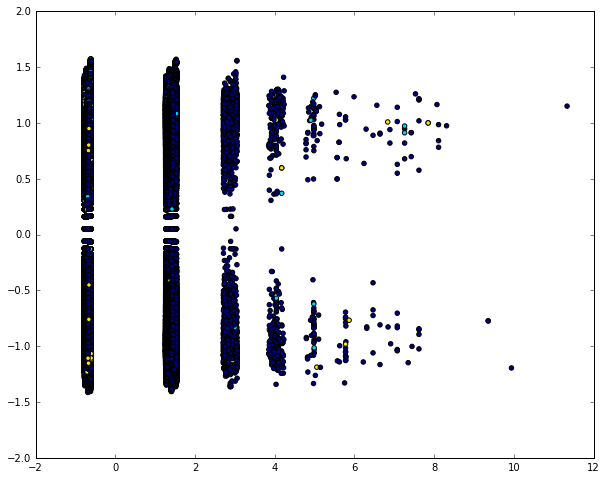

In [50]:
scatter(x=states[:, 0], y=states[:, 1], c=actions)

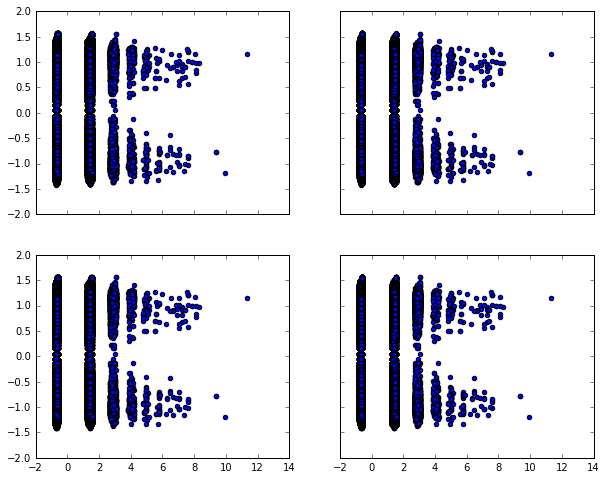

In [51]:
f, axarr = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
for i in range(4):
    points = states
    axarr[i // 2][i % 2].scatter(x=points[:, 0], y=points[:, 1])

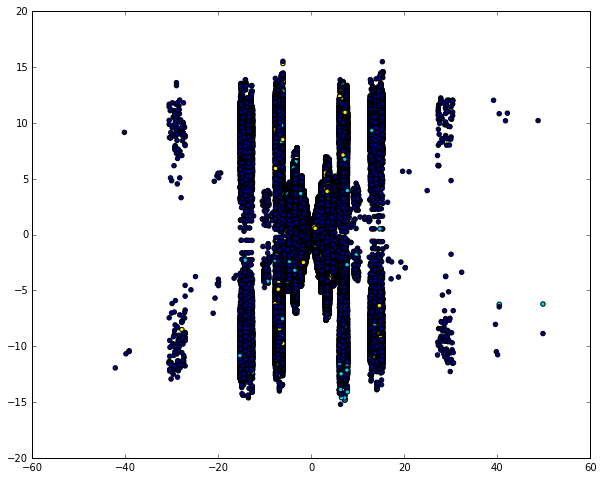

In [52]:
scatter(x=norm_states[:, 0], y=norm_states[:, 1], c=actions[mask])

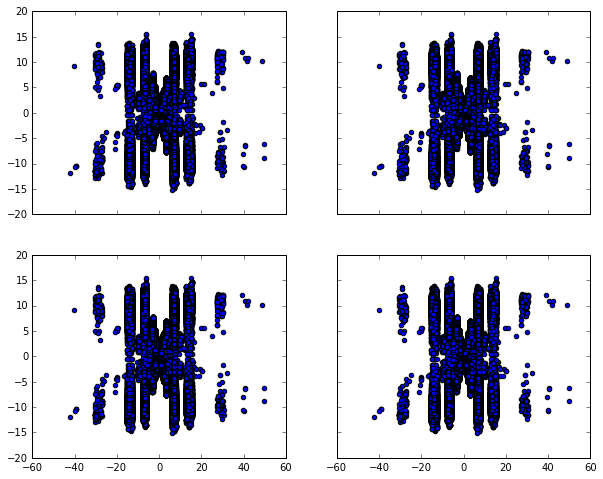

In [53]:
f, axarr = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
for i in range(4):
    points = norm_states
    axarr[i // 2][i % 2].scatter(x=points[:, 0], y=points[:, 1])

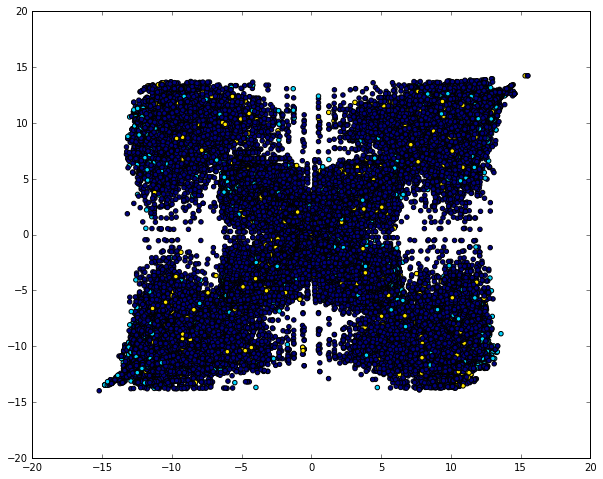

In [54]:
scatter(x=norm_states[:, 1], y=norm_states[:, 2], c=actions[mask])

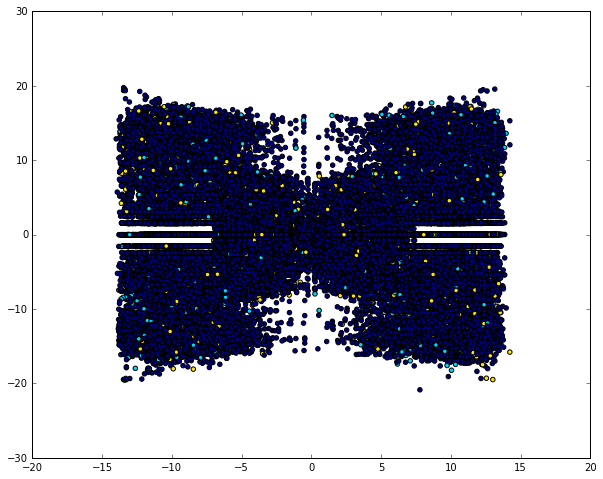

In [55]:
scatter(x=norm_states[:, 2], y=norm_states[:, 3], c=actions[mask])

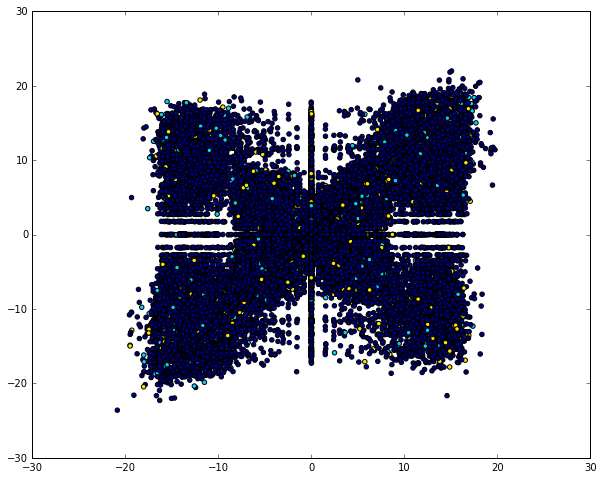

In [56]:
scatter(x=norm_states[:, 3], y=norm_states[:, 4], c=actions[mask])

In [25]:
pca = RandomizedPCA(n_components=2)
transformed = pca.fit_transform(states)

In [26]:
print(pca.explained_variance_ratio_)

[ 0.13732053  0.13164395]


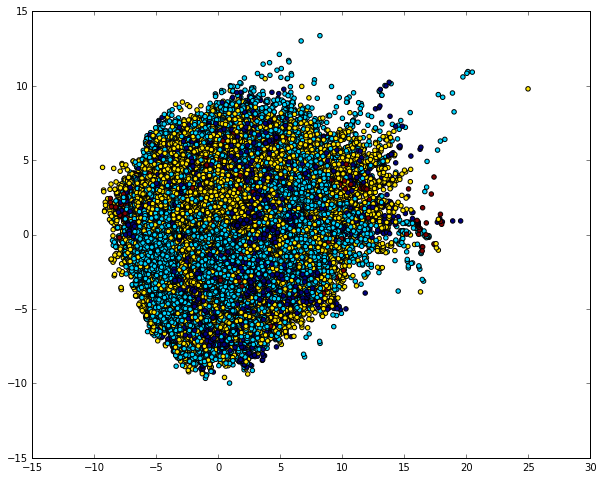

In [27]:
scatter(x=transformed[:, 0], y=transformed[:, 1], c=actions)

In [28]:
norm_pca = RandomizedPCA(n_components=2)
norm_transformed = norm_pca.fit_transform(norm_states)
print(norm_pca.explained_variance_ratio_)

[ 0.14095371  0.11854351]


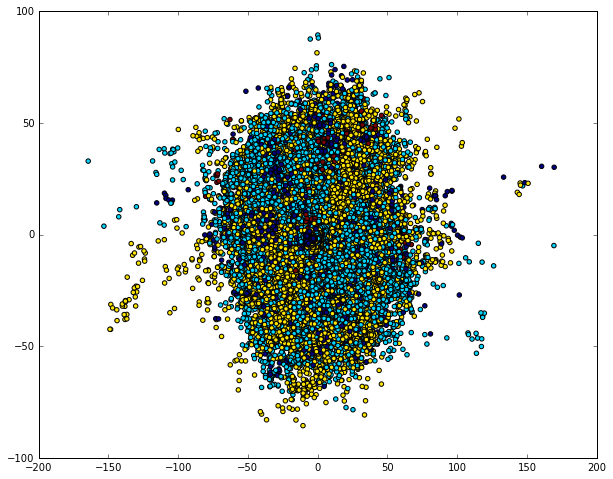

In [29]:
scatter(x=norm_transformed[:, 0], y=norm_transformed[:, 1], c=actions[mask])

In [19]:
norm2_pca = pipeline.make_pipeline(StandardScaler(), RandomizedPCA(n_components=2, random_state=119))
norm2_pca_transformed = norm2_pca.fit_transform(norm_states)

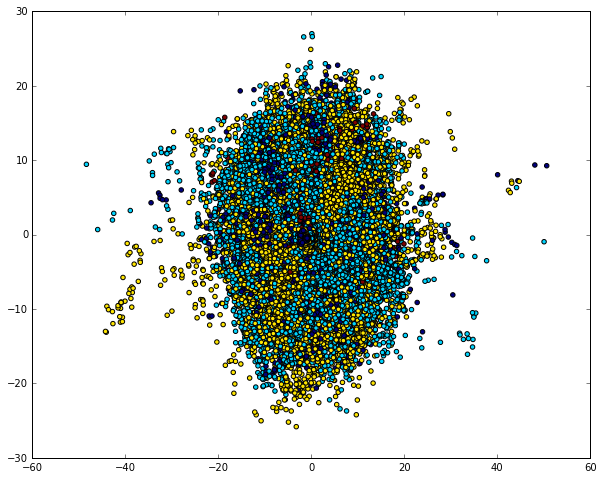

In [20]:
scatter(x=norm2_pca_transformed[:, 0], y=norm2_pca_transformed[:, 1], c=actions[mask])

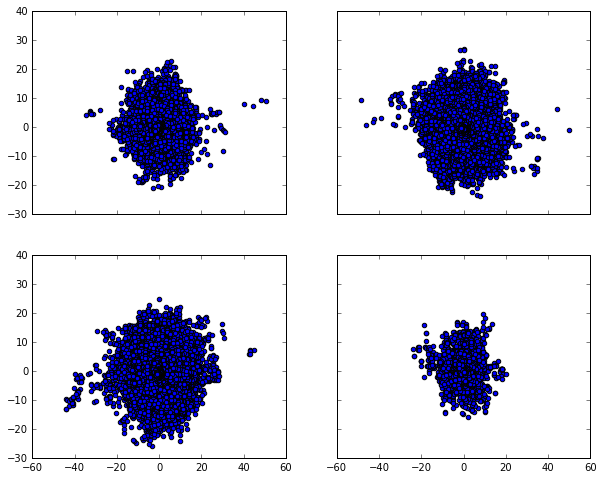

In [21]:
f, axarr = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
for i in range(4):
    action_mask = (actions[mask] == i)
    points = norm2_pca_transformed[:, :2][action_mask]
    axarr[i // 2][i % 2].scatter(x=points[:, 0], y=points[:, 1])

# ICA

In [22]:
norm_ica = FastICA(random_state=119, n_components=2)
norm_ica_transformed = norm_ica.fit_transform(norm_states)

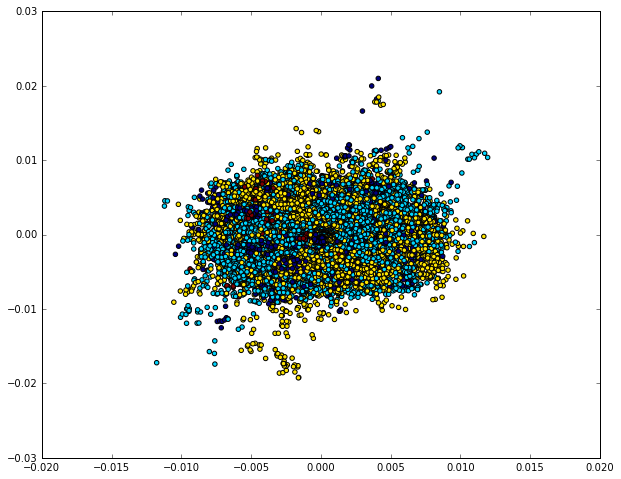

In [23]:
scatter(x=norm_ica_transformed[:, 0], y=norm_ica_transformed[:, 1], c=actions[mask])

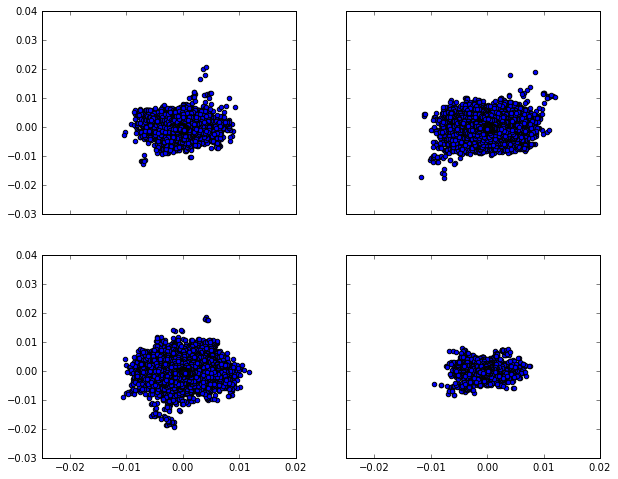

In [24]:
f, axarr = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
for i in range(4):
    action_mask = (actions[mask] == i)
    points = norm_ica_transformed[:, :2][action_mask]
    axarr[i // 2][i % 2].scatter(x=points[:, 0], y=points[:, 1])

In [47]:
norm2_ica = pipeline.make_pipeline(StandardScaler(), FastICA(n_components=2, random_state=119))
norm2_ica_transformed = norm2_ica.fit_transform(norm_states)

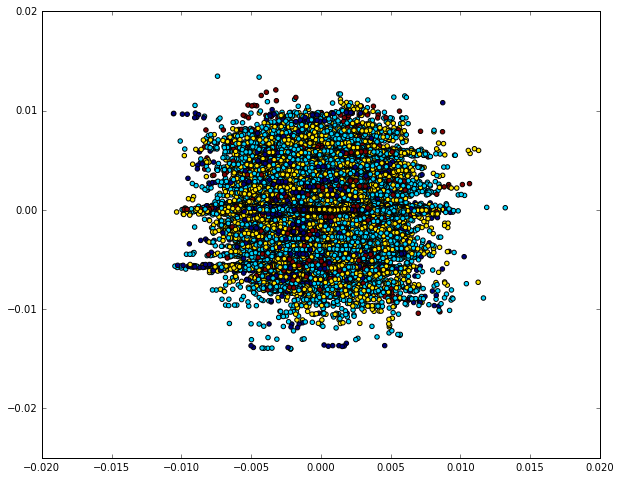

In [48]:
scatter(x=norm2_ica_transformed[:, 0], y=norm2_ica_transformed[:, 1], c=actions[mask])

In [36]:
np.random.seed(37)
small_mask = np.random.choice(np.arange(len(norm_states)), size=3000)
small_norm_states = norm_states[small_mask]
small_actions = actions[small_mask]

In [50]:
norm_kernel_pca = KernelPCA(n_components=2, kernel='poly', degree=2)
small_norm_kernel_transformed = norm_kernel_pca.fit_transform(small_norm_states)
norm_kernel_transformed = norm_kernel_pca.transform(norm_states)

MemoryError: 

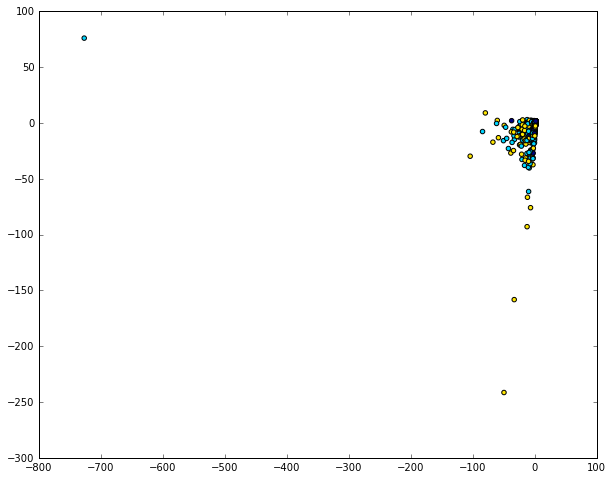

In [51]:
scatter(x=small_norm_kernel_transformed[:, 0], y=small_norm_kernel_transformed[:, 1], c=small_actions)

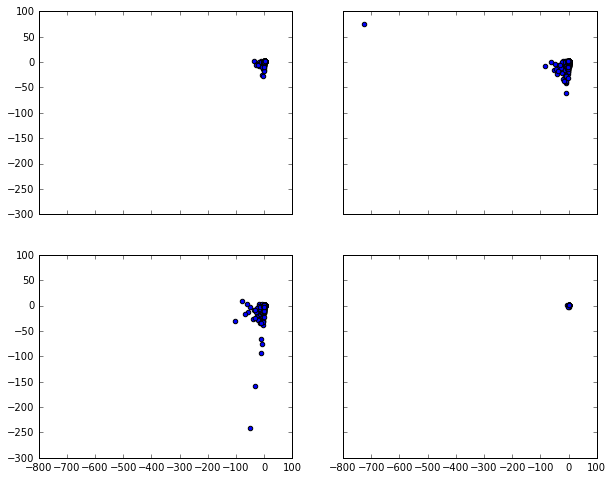

In [52]:
f, axarr = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
for i in range(4):
    action_mask = (small_actions == i)
    points = small_norm_kernel_transformed[:, :2][action_mask]
    axarr[i // 2][i % 2].scatter(x=points[:, 0], y=points[:, 1])

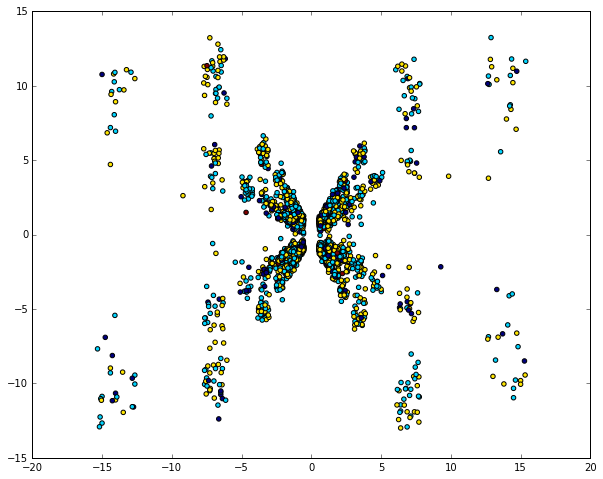

In [45]:
scatter(x=small_norm_states[:, 0], y=small_norm_states[:, 1], c=small_actions)

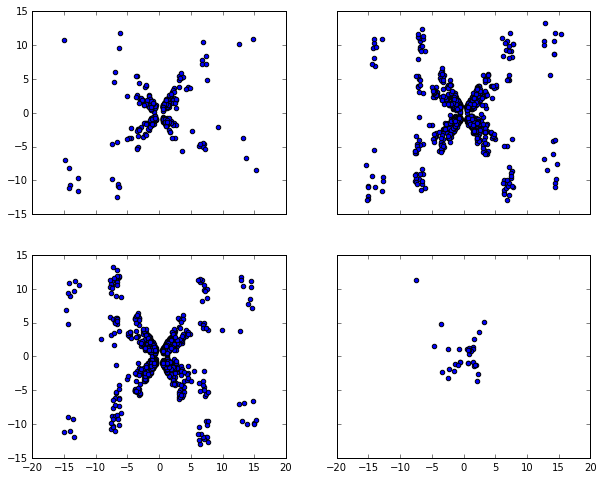

In [43]:
f, axarr = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
for i in range(4):
    action_mask = (small_actions == i)
    points = small_norm_states[:, :2][action_mask]
    axarr[i // 2][i % 2].scatter(x=points[:, 0], y=points[:, 1])

In [ ]:
scatter(x=norm_states[:, 0], y=norm_states[:, 1], c=actions[small_mask])